# Módulo 5: Machine learning y deep learning - Ejercicio de evaluación

In [ ]:
# Importación de librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, accuracy_score, precision_score, recall_score, f1_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.pipeline import Pipeline, FunctionTransformer
from imblearn.over_sampling import SMOTE
import time

## 1. Dataset y Preprocesamiento Inicial

📌 Objetivo: Cargar y limpiar los datos antes del análisis.

- Selección del dataset: Cargar AB_NYC_2019.csv.
- Eliminación de columnas irrelevantes: id, host_id, host_name.
- Gestión de nulos: number_of_reviews (Rellenar con 0), reviews_per_month (Rellenar con 0), last_review (Se eliminará para simplificar).
- Manejo de fechas: Extraer año, mes y día en columnas separadas.
- Eliminar filas con last_review nulo y convertir fecha en 3 columnas.

In [57]:
df = pd.read_csv('../Data/AB_NYC_2019.csv')

# Eliminamos las columnas irrelevantes que no aportan información significativa para el modelo
df.drop(columns=['id', 'host_id', 'host_name'], inplace=True)

# Gestión de los valores nulos: rellenamos 'number_of_reviews' y 'reviews_per_month' con 0, ya que estos valores pueden ser informativos cuando son nulos (es decir, sin reseñas)
df['number_of_reviews'] = df['number_of_reviews'].fillna(0)
df['reviews_per_month'] = df['reviews_per_month'].fillna(0)

# Transformación de la columna de fechas 'last_review' en tres columnas separadas: año, mes y día
df['last_review'] = pd.to_datetime(df['last_review'], errors='coerce')
df['year'], df['month'], df['day'] = df['last_review'].dt.year, df['last_review'].dt.month, df['last_review'].dt.day

# Eliminamos las filas donde 'last_review' sigue siendo nulo (no tiene sentido procesar estos registros)
df.dropna(subset=['last_review'], inplace=True)

# Eliminamos la columna 'last_review' ya que ahora la hemos desglosado en otras tres columnas
df.drop(columns=['last_review'], inplace=True)

# Restablecemos el índice para que el DataFrame sea limpio después de los cambios
df.reset_index(drop=True, inplace=True)

# Mostramos las primeras filas para ver el estado actual de los datos
df.head()

,name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,year,month,day
0,Clean & quiet apt home by the park,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,0.21,6,365,2018.0,10.0,19.0
1,Skylit Midtown Castle,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,0.38,2,355,2019.0,5.0,21.0
2,Cozy Entire Floor of Brownstone,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,4.64,1,194,2019.0,7.0,5.0
3,Entire Apt: Spacious Studio/Loft by central park,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,0.10,1,0,2018.0,11.0,19.0
4,Large Cozy 1 BR Apartment In Midtown East,Manhattan,Murray Hill,40.74767,-73.97500,Entire home/apt,200,3,74,0.59,1,129,2019.0,6.0,22.0


## 2. Análisis Exploratorio de Datos (EDA)
📌 Objetivo: Identificar patrones y relaciones en los datos.

- Histogramas, boxplots, countplots (Univariante).
- Scatterplots (Bivariante).
- Heatmap de correlación y Pairplot (Multivariante).

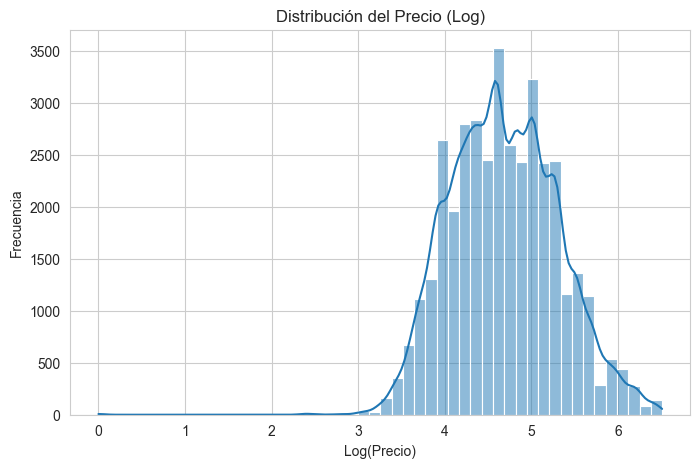

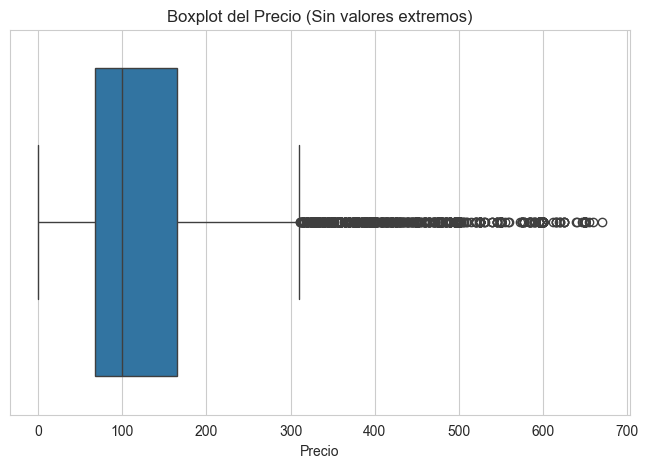

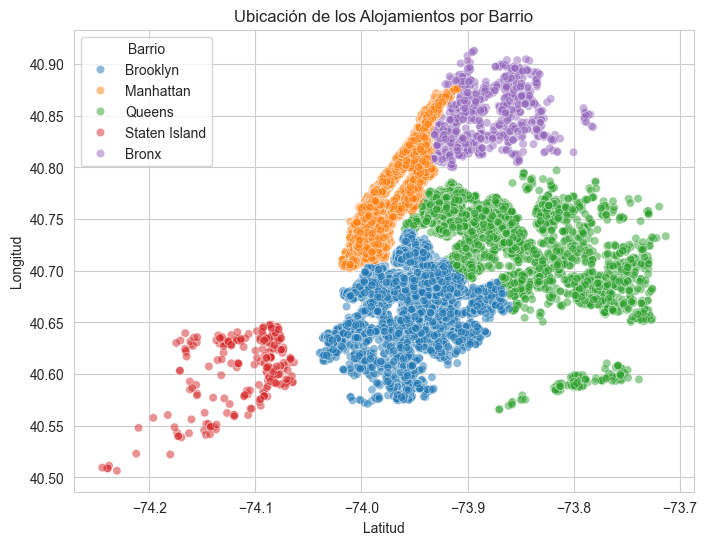

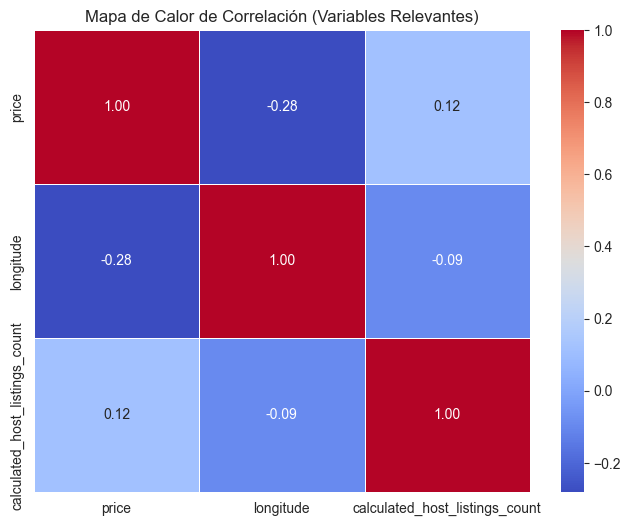

In [ ]:
sns.set_style("whitegrid")

# Eliminamos los valores atípicos en la columna 'price', ya que podrían distorsionar el análisis
df_filtered = df[df["price"] < df["price"].quantile(0.99)]

# Un análisis univariado de la distribución de precios utilizando una transformación logarítmica
plt.figure(figsize=(8, 5))
sns.histplot(np.log1p(df_filtered["price"]), bins=50, kde=True)
plt.title('Distribución del Precio (Log)')  # Título de la gráfica
plt.xlabel('Log(Precio)')  # Etiqueta del eje x
plt.ylabel('Frecuencia')  # Etiqueta del eje y
plt.show()

# Boxplot para visualizar la dispersión de los precios sin los valores extremos
plt.figure(figsize=(8, 5))
sns.boxplot(x=df_filtered["price"])
plt.title('Boxplot del Precio (Sin valores extremos)')
plt.xlabel('Precio')
plt.show()

# Realizamos un Countplot para ver la distribución de los tipos de barrios
plt.figure(figsize=(8, 6))
sns.scatterplot(x=df_filtered["longitude"], y=df_filtered["latitude"], hue=df_filtered["neighbourhood_group"], alpha=0.5)
plt.title('Ubicación de los Alojamientos por Barrio')
plt.xlabel('Latitud')  # Etiqueta correcta para la latidud
plt.ylabel('Longitud')  # Etiqueta correcta para la longitud
plt.legend(title="Barrio")
plt.show()

# Análisis multivariante: Creamos un mapa de calor para explorar la correlación entre las variables numéricas
numeric_cols = df_filtered.select_dtypes(include=[np.number])
correlation = numeric_cols.corr()["price"].abs().sort_values(ascending=False)

# Seleccionamos las características que tienen una correlación significativa con 'price'
relevant_features = correlation[correlation > 0.1].index
plt.figure(figsize=(8, 6))
sns.heatmap(df_filtered[relevant_features].corr(), annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title('Mapa de Calor de Correlación (Variables Relevantes)')
plt.show()

## 3. Preprocesamiento de Datos
📌 Objetivo: Transformar los datos para que sean utilizables en modelos de Machine Learning.

Variables numéricas:

- Imputación con SimpleImputer.
- Escalado con StandardScaler, MinMaxScaler, PowerTransformer o RobustScaler si hay outliers.
-  Transformar price con np.log para mejorar la predicción.

Variables categóricas:

- Imputación con SimpleImputer.
- Codificación con OrdinalEncoder o OneHotEncoder.
- Aplicar reducción de dimensionalidad con PCA o SelectKBest si OneHotEncoder genera demasiadas columnas.
- Vectorizar la columna name con TruncatedSVD para reducción de dimensiones.

Implementar Pipelines de Scikit-Learn para automatizar la transformación de datos.

In [59]:
# Definimos las características numéricas y categóricas para su posterior procesamiento
num_features = ["number_of_reviews", "reviews_per_month"]  
cat_features = ["neighbourhood_group", "room_type"]  

# Creamos un pipeline para las variables numéricas
num_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),  # Rellenamos los nulos con la mediana
    ("log_transform", FunctionTransformer(np.log1p, validate=False)),  # Aplicamos logaritmo a los valores para reducir sesgo
    ("scaler", StandardScaler())  # Normalizamos las características numéricas
])

# Creamos un pipeline para las variables categóricas
cat_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),  # Rellenamos los nulos con el valor más frecuente
    ("encoder", OneHotEncoder(handle_unknown="ignore"))  # Codificamos las variables categóricas con OneHotEncoding
])

# Aplicamos el preprocesador que aplica ambos pipelines a las columnas correspondientes
preprocessor = ColumnTransformer([
    ("num", num_pipeline, num_features),
    ("cat", cat_pipeline, cat_features)
])

# Aplicamos la transformación a nuestros datos
df_processed = preprocessor.fit_transform(df)

# Aplicamos reducción de dimensionalidad usando PCA (análisis de componentes principales)
pca = PCA(n_components=0.95)  # Conservamos el 95% de la varianza
df_processed = pca.fit_transform(df_processed)

# Verificamos la nueva forma de los datos procesados después de la reducción de dimensionalidad
print(f"Datos procesados, nueva forma: {df_processed.shape}")

Datos procesados, nueva forma: (38843, 5)


## 4. Clustering y Evaluación con Siluetas
📌 Objetivo: Agrupar los datos para encontrar patrones ocultos.

- Aplicar KMeans u otro método de clustering para crear una columna cluster.
- Visualizar los clusters con un scatterplot (hue = cluster).

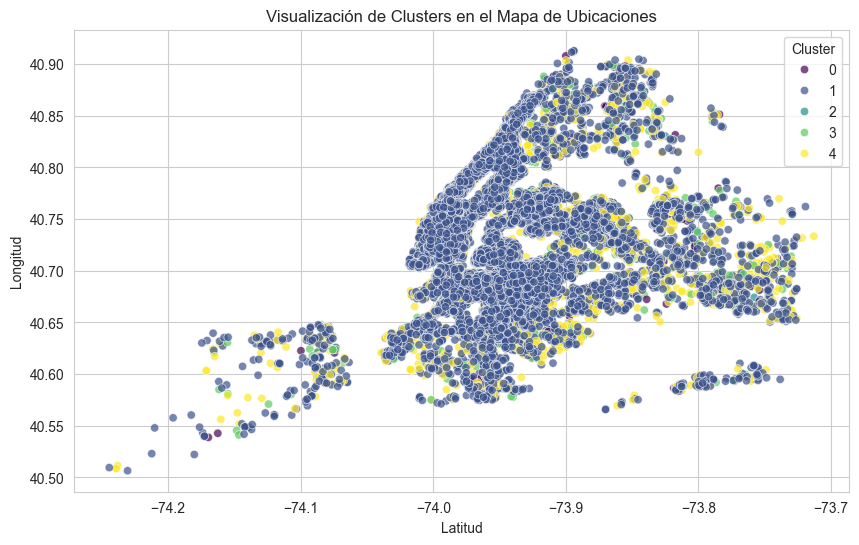

In [ ]:
# Realizamos un clustering utilizando KMeans para agrupar los alojamientos en 5 grupos (clusters)
kmeans = KMeans(n_clusters=5, random_state=42)
df["cluster"] = kmeans.fit_predict(df[num_features])

# Visualizamos los clusters sobre el mapa de ubicaciones geográficas
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df["longitude"], y=df["latitude"], hue=df["cluster"], palette="viridis", alpha=0.7)
plt.title('Visualización de Clusters en el Mapa de Ubicaciones')
plt.xlabel('Latitud')
plt.ylabel('Longitud')
plt.legend(title="Cluster")
plt.show()

## 5. Selección de Características
📌 Objetivo: Reducir la cantidad de variables y mejorar el rendimiento del modelo.

- Aplicar SelectKBest para selección de mejores columnas en regresión.
- Aplicar PCA para reducción de dimensiones en clasificación.
- Comparar resultados de ambos métodos y elegir el mejor.

In [61]:
X, y = df.drop(columns=['price']), df['price']

# Identificación de las variables numéricas y categóricas para el preprocesamiento
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

# Creamos un ColumnTransformer para el preprocesamiento de los datos
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
])

# Dividimos los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Aplicamos la transformación a los datos de entrenamiento y prueba
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# Realizamos una selección de las mejores características usando SelectKBest
select_kbest = SelectKBest(score_func=f_regression, k=5)  # Seleccionamos las 5 mejores características
X_train_kbest = select_kbest.fit_transform(X_train_processed, y_train)
X_test_kbest = select_kbest.transform(X_test_processed)

# Entrenamos un modelo de regresión lineal usando las características seleccionadas
model_kbest = LinearRegression().fit(X_train_kbest, y_train)

# Calculamos el MSE y R² en el conjunto de prueba
mse_kbest = mean_squared_error(y_test, model_kbest.predict(X_test_kbest))
r2_kbest = r2_score(y_test, model_kbest.predict(X_test_kbest))

# Aplicamos PCA para reducción de dimensionalidad
pca = PCA(n_components=5)
X_train_pca = pca.fit_transform(X_train_processed)
X_test_pca = pca.transform(X_test_processed)

# Entrenamos un modelo de regresión lineal usando los componentes principales
model_pca = LinearRegression().fit(X_train_pca, y_train)

# Calculamos el MSE y R² con PCA
mse_pca = mean_squared_error(y_test, model_pca.predict(X_test_pca))
r2_pca = r2_score(y_test, model_pca.predict(X_test_pca))

# Comparar los resultados de los dos métodos
print(f"MSE con SelectKBest: {mse_kbest}")
print(f"R2 con SelectKBest: {r2_kbest}")
print(f"MSE con PCA: {mse_pca}")
print(f"R2 con PCA: {r2_pca}")

# Determinamos el mejor método basado en MSE y R²
best_method = "SelectKBest" if mse_kbest < mse_pca else "PCA"
print(f"Mejor método: {best_method} (MSE: {min(mse_kbest, mse_pca)}, R2: {max(r2_kbest, r2_pca)})")

MSE con SelectKBest: 25312.790057395214
R2 con SelectKBest: 0.1203049194725464
MSE con PCA: 27126.3902105143
R2 con PCA: 0.05727689572940353
Mejor método: SelectKBest (MSE: 25312.790057395214, R2: 0.1203049194725464)


## 6. Modelado

Regresión

📌 Objetivo: Predecir el precio del alojamiento (price).

- Predecir price usando modelos como LinearRegression, RandomForestRegressor, etc.
- Comparar métricas como MAE, MSE, RMSE y R².

Clasificación Multiclase

- Predecir room_type con modelos como LogisticRegression, RandomForestClassifier, etc.
- Comparar métricas como Accuracy, Precision, Recall y F1-score.
- Aplicar SMOTE si hay desbalanceo en room_type

In [63]:
# Creamos y entrenamos los modelos de regresión
reg_models = {
    "Linear Regression": LinearRegression(),
    "Random Forest Regressor": RandomForestRegressor(random_state=42)
}

# Evaluamos los modelos utilizando métricas de error
reg_results = {}

for model_name, model in reg_models.items():
    model.fit(X_train_kbest, y_train)  # Entrenamos el modelo con las características seleccionadas
    y_pred = model.predict(X_test_kbest)
    
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    
    reg_results[model_name] = {"MAE": mae, "MSE": mse, "RMSE": rmse, "R2": r2}

# Mostramos los resultados de los modelos
reg_results_df = pd.DataFrame(reg_results).T
print(reg_results_df)

                               MAE           MSE        RMSE        R2
Linear Regression        62.998501  25312.790057  159.099937  0.120305
Random Forest Regressor  62.964589  25313.949627  159.103581  0.120265


## 7. Validación y Comparación de Modelos
📌 Objetivo: Evaluar el rendimiento de los modelos.

- Aplicar validación cruzada con cross_val_score.
- Mostrar resultados en un DataFrame.
- Graficar boxplots de tiempos de ejecución y métricas.
- Usar GridSearchCV para optimizar hiperparámetros de los modelos.

                         MSE Promedio  R2 Promedio
Linear Regression        38172.522853     0.079666
Random Forest Regressor  38172.110560     0.079675


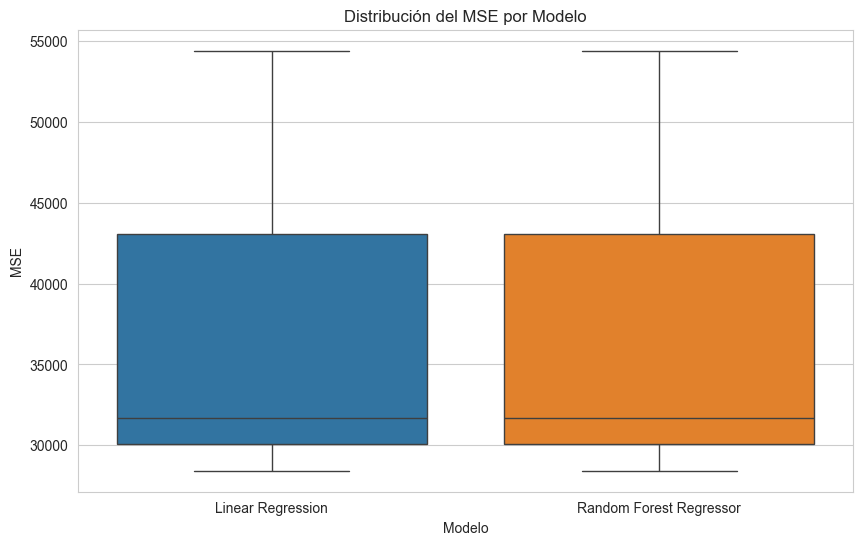

In [76]:
cv_results = {}

# Realiza la validación cruzada y calcula el MSE y R² promedio
for model_name, model in reg_models.items():
    cv_mse = -cross_val_score(model, X_train_kbest, y_train, cv=3, scoring='neg_mean_squared_error')
    cv_r2 = cross_val_score(model, X_train_kbest, y_train, cv=3, scoring='r2')
    
    cv_results[model_name] = {
        "MSE Promedio": np.mean(cv_mse),
        "R2 Promedio": np.mean(cv_r2)
    }

# Visualización de los resultados de la validación cruzada
cv_results_df = pd.DataFrame(cv_results).T
print(cv_results_df)

# Definir 'model_names' (nombres de los modelos)
model_names = list(reg_models.keys())  # Esto obtiene los nombres de los modelos del diccionario

# Extraer los valores de MSE para graficarlos
mse_values = [-cross_val_score(model, X_train_kbest, y_train, cv=3, scoring='neg_mean_squared_error') 
              for model in reg_models.values()]

# Graficamos el boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(data=mse_values)
plt.xticks(ticks=range(len(model_names)), labels=model_names)  # Aquí usamos 'model_names'
plt.title("Distribución del MSE por Modelo")
plt.xlabel("Modelo")
plt.ylabel("MSE")
plt.show()